In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_first_tract_data, reconstruction_loss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import VariationalAutoencoder

/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#This notebook runs a simple autoencoder on just first tract of each AFQ dataset sample, and visualizes the difference the dropout value has on the best loss. 

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100

File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [9]:
def random_train_multiple_tracts_experiment(
    self, train_data, val_data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.03
):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')  # Track the best (lowest) validation RMSE overall

    for epoch in range(epochs):
        # Training
        self.train()
        running_loss = 0
        running_rmse = 0
        items = 0

        for x, _ in train_data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)
            # For simplicity, using only the first tract in training
            tract_data = x[:, 0:1, :]

            # Apply jitter augmentation
            tract_data = tract_data.to(torch.float32).numpy()
            tract_data = aug.jitter(tract_data, sigma=sigma)
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)
            

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            # Compute RMSE for the batch
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

            # Backward pass
            loss.backward()
            opt.step()

            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)

        # Validation
        self.eval()
        val_rmse = 0
        val_items = 0

        with torch.no_grad():
            for x, _ in val_data:
                batch_size = x.size(0)
                # For simplicity, using the first tract in validation as well
                tract_data = x[:, 0:1, :]

                # Apply jitter augmentation
                tract_data = tract_data.to(torch.float32).numpy()
                tract_data = aug.jitter(tract_data, sigma=sigma)
                tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

                # Forward pass
                x_hat = self(tract_data)

                # Compute RMSE for the batch
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)

        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)

        # Update best validation loss if improved
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse

        print(
            f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}"
        )

    return train_rmse_per_epoch, val_rmse_per_epoch, best_val_loss


In [10]:
torch_dataset, first_tract_train_loader, first_tract_test_loader, first_tract_val_loader = prep_first_tract_data(
    dataset, batch_size=64
)

In [11]:
dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_rmse_results = {}
val_rmse_results = {}
best_val_results = {}

for dropout in dropout_values:
    print(f"\nTraining with dropout = {dropout}")
    vae_one_tract = VariationalAutoencoder(in_channels, latent_dims=20, dropout=dropout).to(device)
    train_rmse, val_rmse, best_val_loss = random_train_multiple_tracts_experiment(
        vae_one_tract, first_tract_test_loader, first_tract_val_loader, epochs=100, lr=1e-3, num_selected_tracts=8
    )
    train_rmse_results[dropout] = train_rmse
    val_rmse_results[dropout] = val_rmse
    best_val_results[dropout] = best_val_loss


Training with dropout = 0
Epoch 1, Train RMSE: 0.5080, Val RMSE: 0.4649
Epoch 2, Train RMSE: 0.4392, Val RMSE: 0.4033
Epoch 3, Train RMSE: 0.3779, Val RMSE: 0.3432
Epoch 4, Train RMSE: 0.3160, Val RMSE: 0.2754
Epoch 5, Train RMSE: 0.2548, Val RMSE: 0.2332
Epoch 6, Train RMSE: 0.2103, Val RMSE: 0.1822
Epoch 7, Train RMSE: 0.1712, Val RMSE: 0.1514
Epoch 8, Train RMSE: 0.1434, Val RMSE: 0.1313
Epoch 9, Train RMSE: 0.1269, Val RMSE: 0.1160
Epoch 10, Train RMSE: 0.1090, Val RMSE: 0.1042
Epoch 11, Train RMSE: 0.0987, Val RMSE: 0.0916
Epoch 12, Train RMSE: 0.0863, Val RMSE: 0.0820
Epoch 13, Train RMSE: 0.0783, Val RMSE: 0.0752
Epoch 14, Train RMSE: 0.0719, Val RMSE: 0.0712
Epoch 15, Train RMSE: 0.0686, Val RMSE: 0.0670
Epoch 16, Train RMSE: 0.0650, Val RMSE: 0.0652
Epoch 17, Train RMSE: 0.0628, Val RMSE: 0.0621
Epoch 18, Train RMSE: 0.0609, Val RMSE: 0.0600
Epoch 19, Train RMSE: 0.0585, Val RMSE: 0.0591
Epoch 20, Train RMSE: 0.0581, Val RMSE: 0.0583
Epoch 21, Train RMSE: 0.0573, Val RMSE: 0.

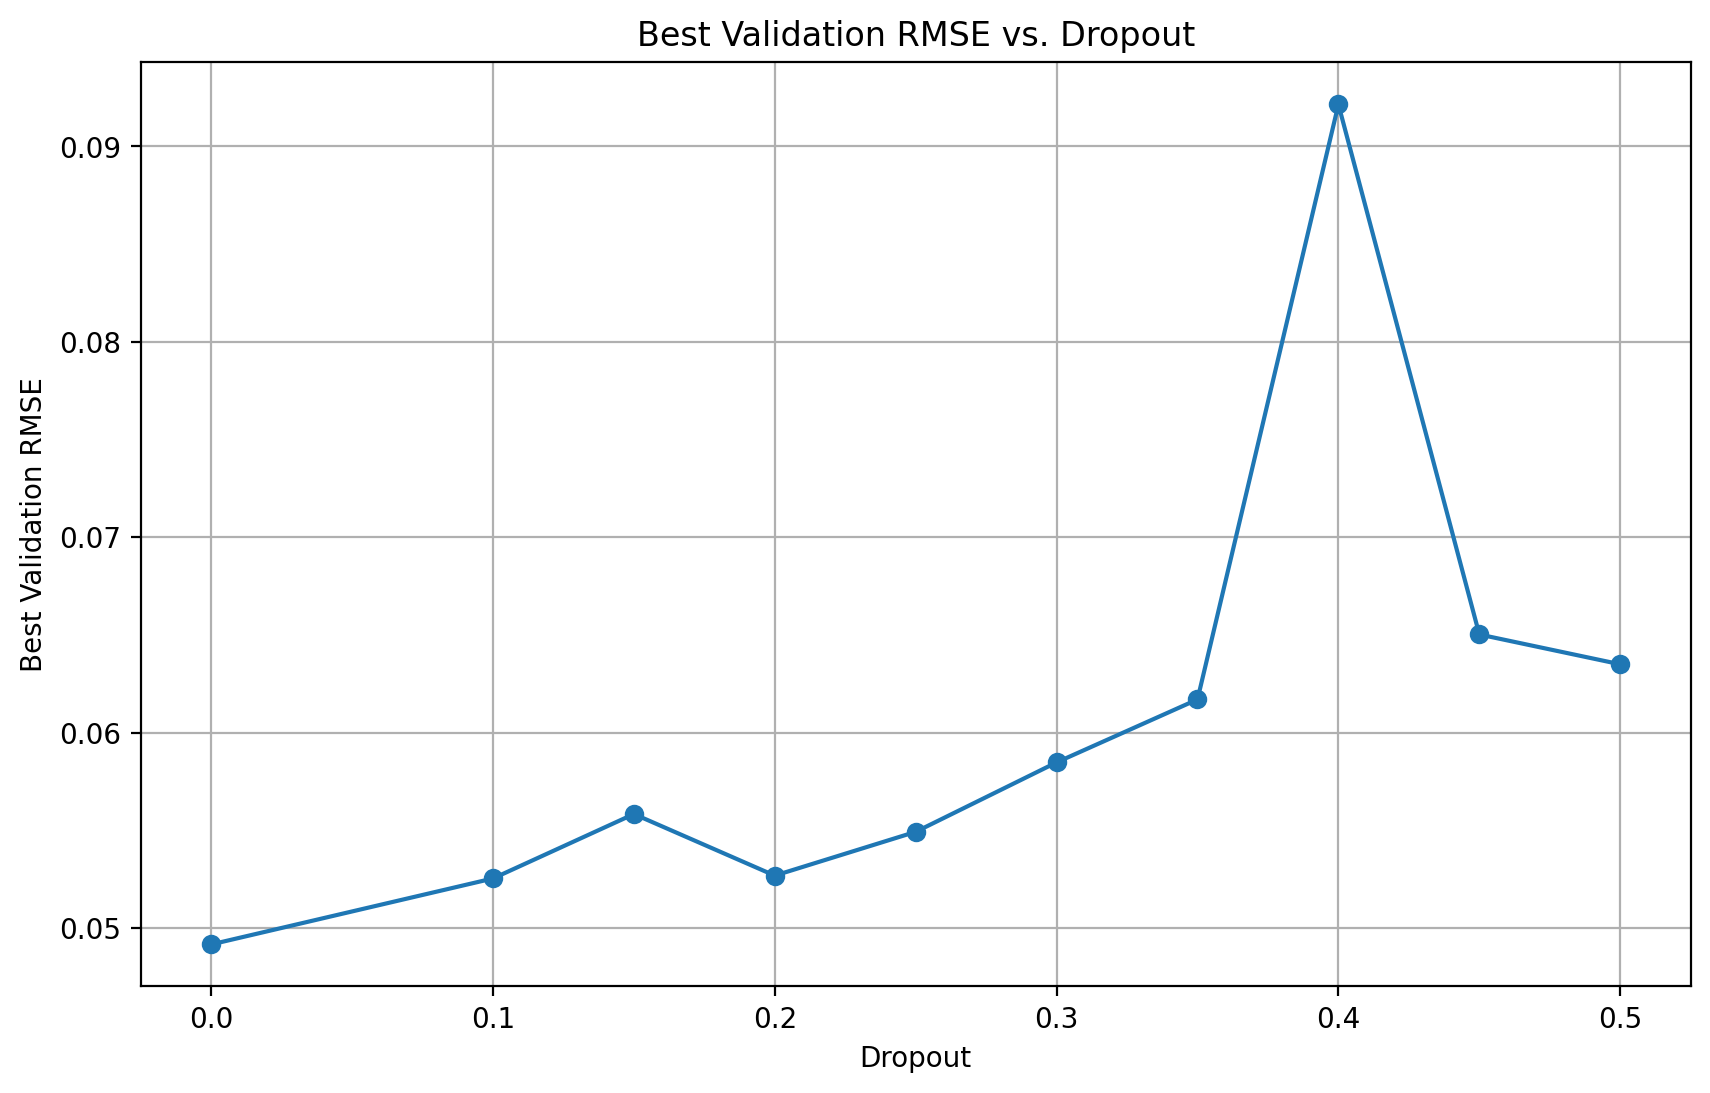

In [12]:
# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()

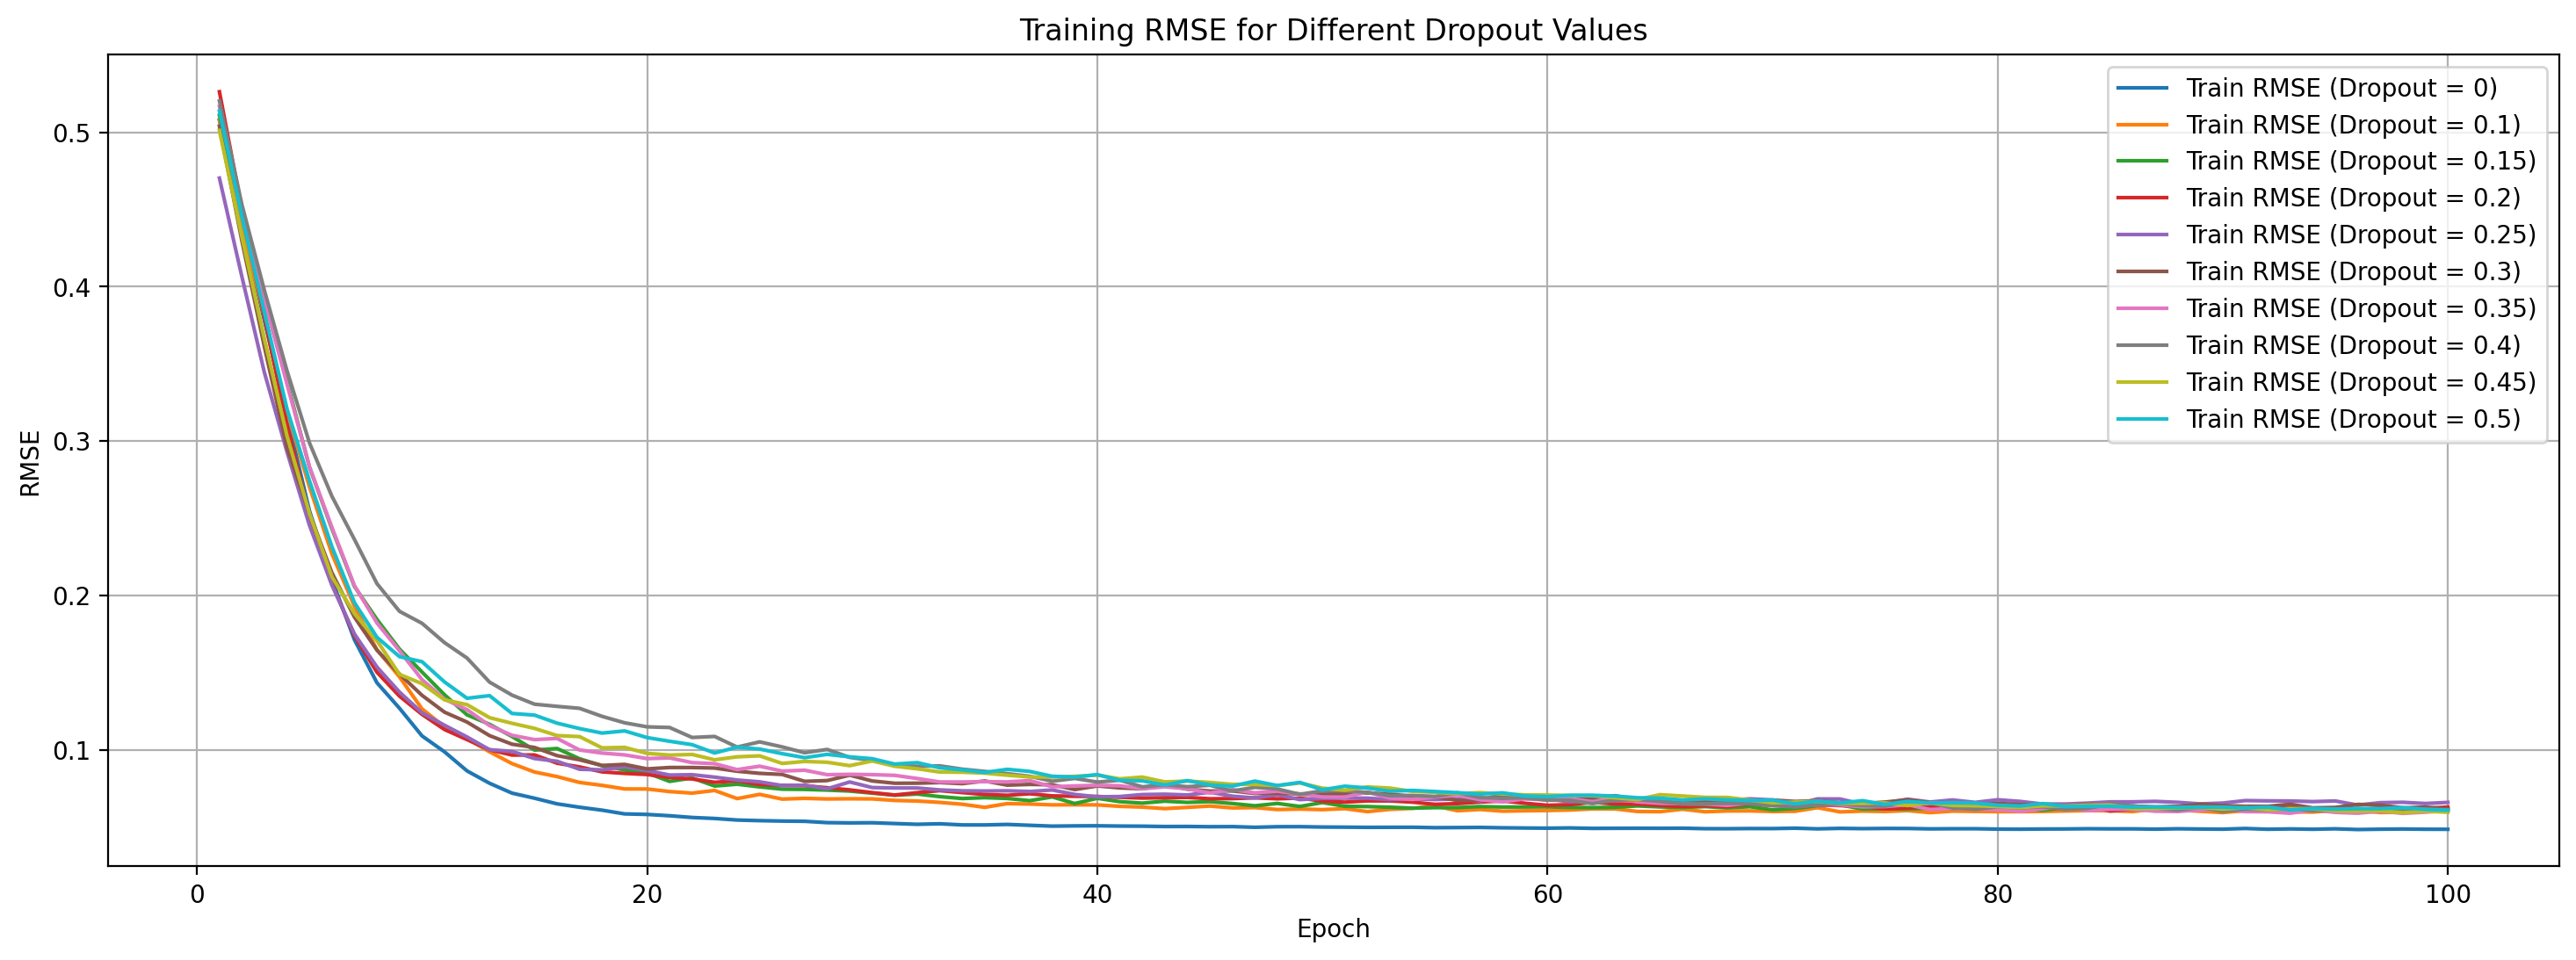

In [13]:
# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

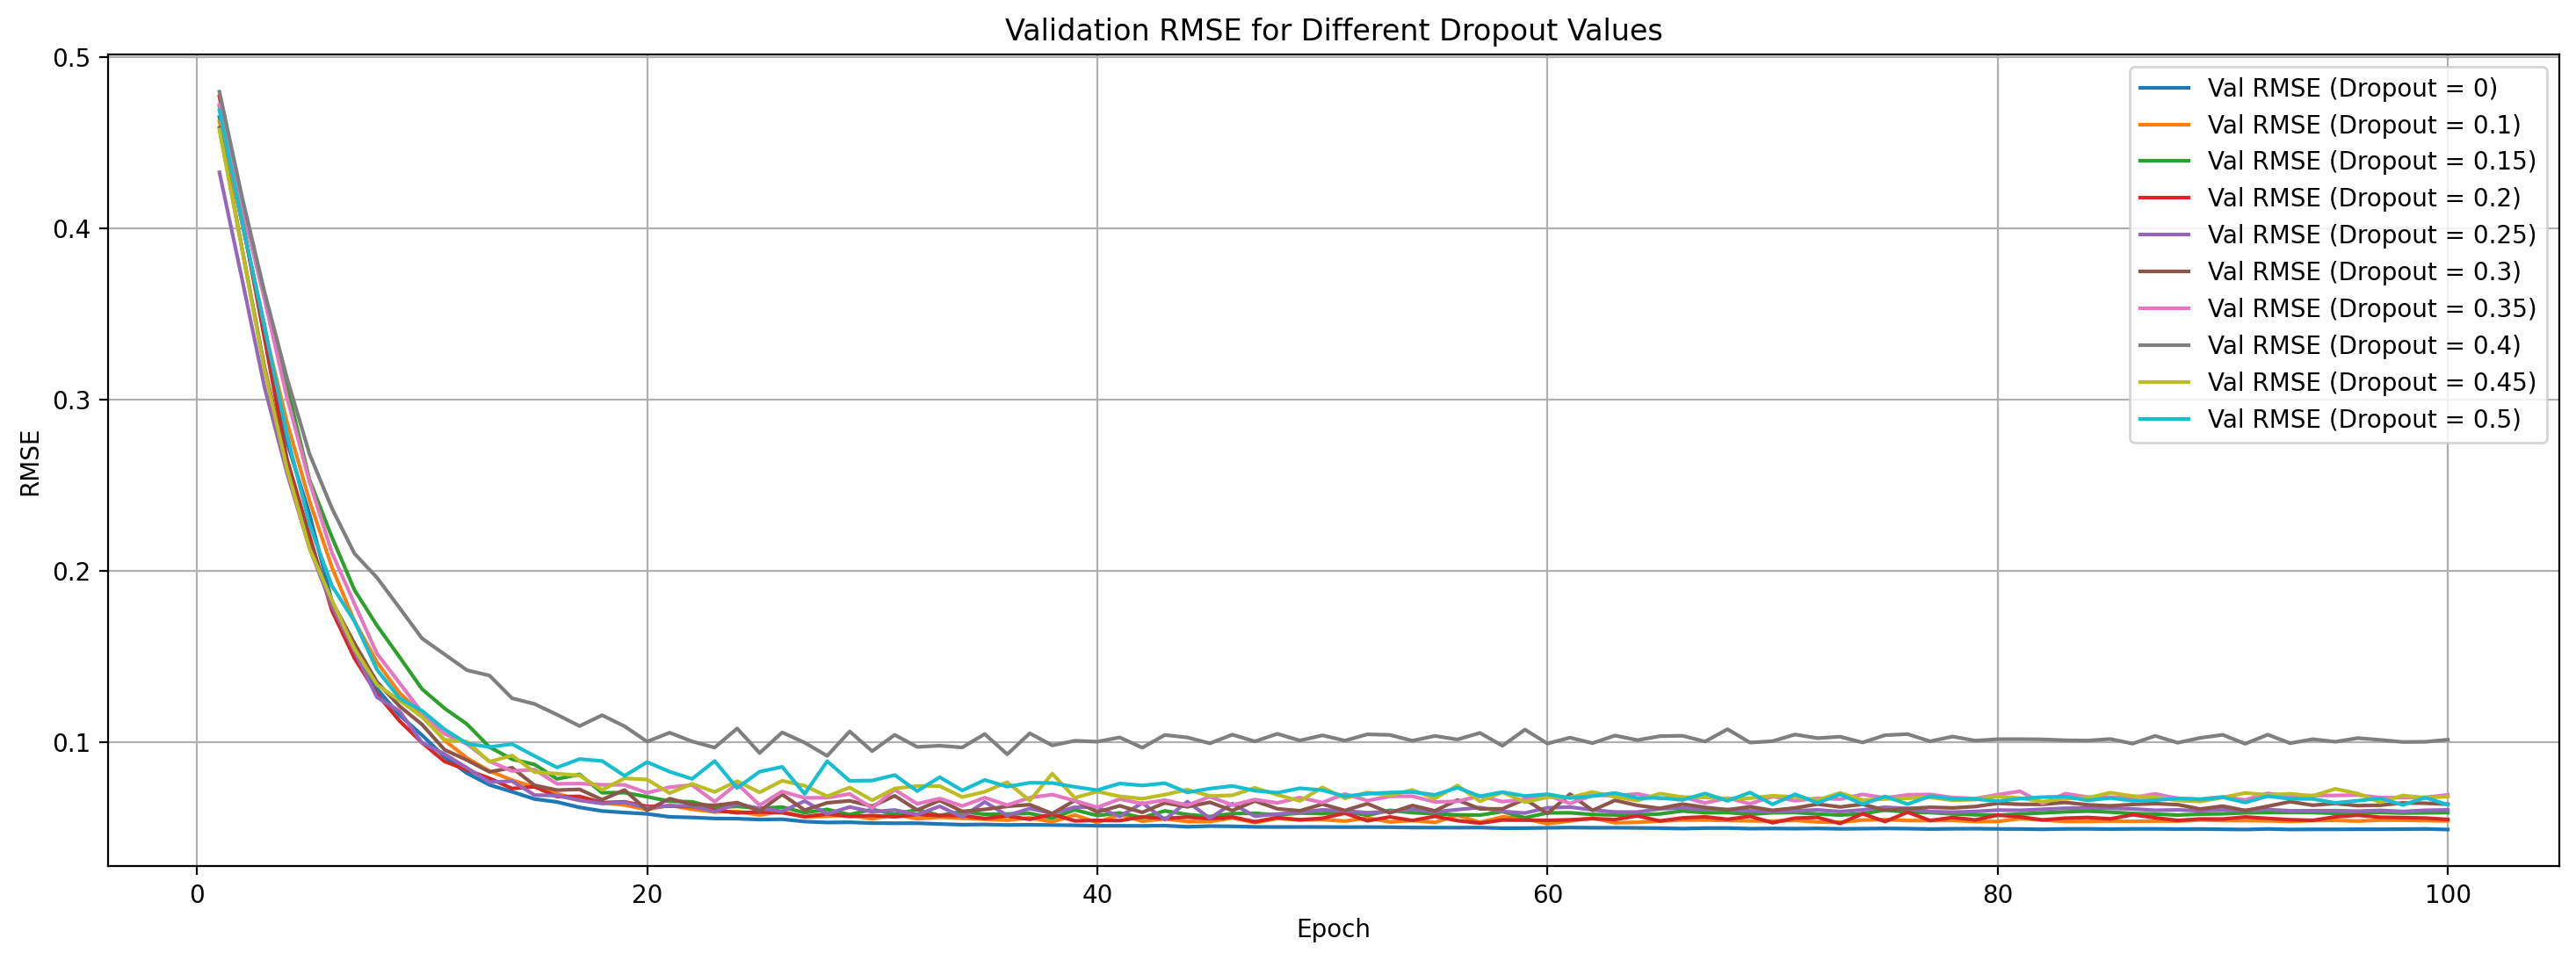

In [14]:
# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

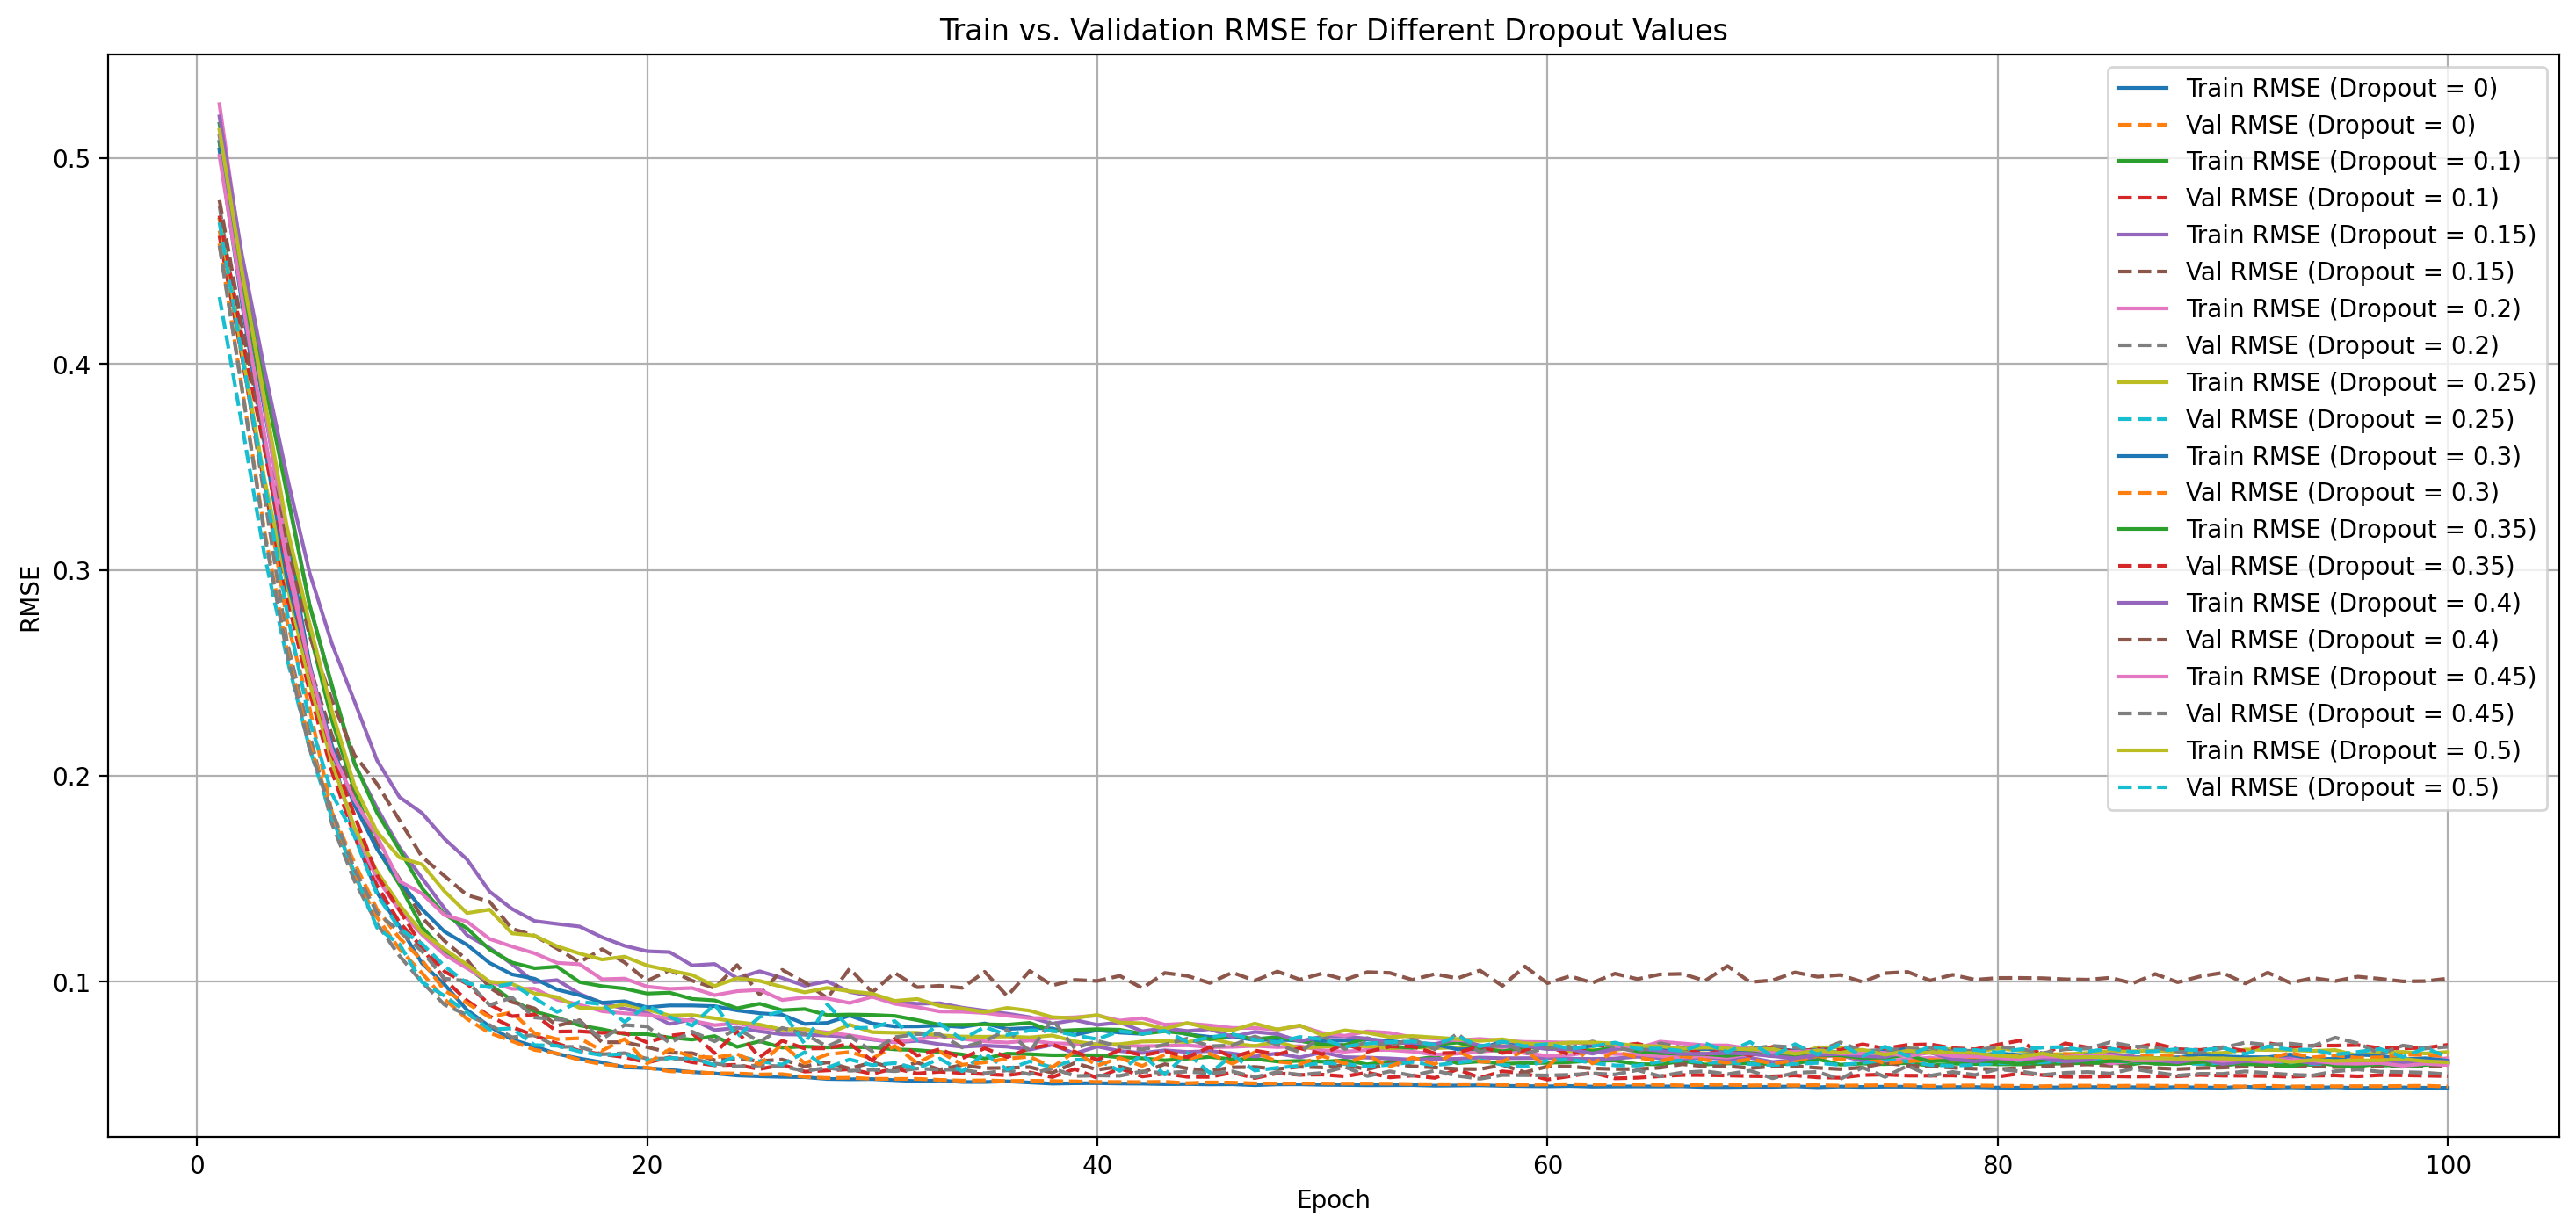

In [15]:
# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()
